%Programs step1, 2, an 3 are for a reversed refraction profile
%to obtain the input for seisdip.exe a DOS dipping layer refraction program.
%step1 plots the forward and reverse seismic sections. step 2 
%is used to pick first arrivals.  Step3 allows you to time the branches and
%obtain velocities and intercepts needed for seisdip. You will need to set nb in step 3 
%which determiones the number of branches to be picked in the data.
%In step 3 you can ensure reciprocity (necessary to < 10 ms if seisdip is to run
% successfully) by picking the total travel times of the forward branches as one 
%of the 2 points defining a reverse branch.  
%Make sure if you change files to change variable names
%seis=, in the code; 
%nodata=no. data points; gain is amplification; nostation is number t
%Clear previous data and plots.
%INPUT ascii files with seismgrams in columns (e.g., fl103.txt, fl106.txt)
%      from RAS saved as ascii files.
%      nodata=number of data
%      gain=amplification
%      nostations=number of seismograms to be used
%      station1= first station to be used
%      =time interval between data points
%      dx=spacing between stations
%Associated Programs plotseis.m

% CHANGE IN 4 PLACES 
% LINES 31-32 INPUT shots
% LINES 38-42 input data
% LINES 54, 66  Shot number from lines 31,32
% LINES 62, 69  Shot number from lines 31,32

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from obspy.signal.filter import bandpass
from obspy.signal.detrend import polynomial
%matplotlib notebook


In [2]:
nodata=300
dt=1/1000
nostations=48
dx=5
rlength=(nostations)*dx
station1=0
stationn=station1+nostations-1
numpicks=49
nbranch=2
f0=40;width=f0^2
fflag=1

seisS1=np.genfromtxt('data/Saturday/South/04.txt') #direct wave
seisS2=np.genfromtxt('data/Saturday/South/07.txt') #direct wave
tseis1='South'
seis1=np.hstack((seisS1,seisS2))
seisN1=np.genfromtxt('data/Saturday/North/01.txt'); #reverse wave
seisN2=np.genfromtxt('data/Saturday/North/05.txt'); #reverse wave

tseis2='North'
seis2=np.hstack((seisN1,seisN2))



In [158]:
def plotseis(seis,doublecolor=False):
    fig =plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    for i in range(nostations):
    #     tr.normalize()
        tr=seis[:nodata,i]
    #     tr = minmax_scale(tr, feature_range=(-1,1))
        tr=polynomial(tr, order=3, plot=False)  
        tr=bandpass(tr,0.1,40,1/dt)
        tr=tr/tr.max()*5
        dist = dx*i+dx
        y = np.arange(nodata)*dt
        x = tr+dist
        ax.plot(x,y,'k')
        ax.fill_betweenx(y,x,dist,x > dist, color='r', alpha = 0.8)
        if doublecolor:
            ax.fill_betweenx(y,x,dist,x < dist, color='b', alpha = 0.8)

    ax.set_xlabel("Station Dist")    
    ax.set_ylabel("sec")    
    ax.set_ylim(0,0.3)
    ax.set_xlim(0,250)
#     plt.tight_layout()
    plt.gca().invert_yaxis()

    return fig, ax
    
def onclick(event):
#     tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    if len(picks) == nostations:
        np.save(filename,np.array(sorted(picks)))
        fig.canvas.mpl_disconnect(cid) 
        return 
    picks.append((event.xdata,event.ydata))
    tx = 'button=%d, x=%f, y=%f ' % (len(picks), event.xdata, event.ydata)
    text.set_text(tx)
    plt.plot(event.xdata,event.ydata,'g+',markersize=15,markeredgewidth=3)
    plt.show()



<IPython.core.display.Javascript object>


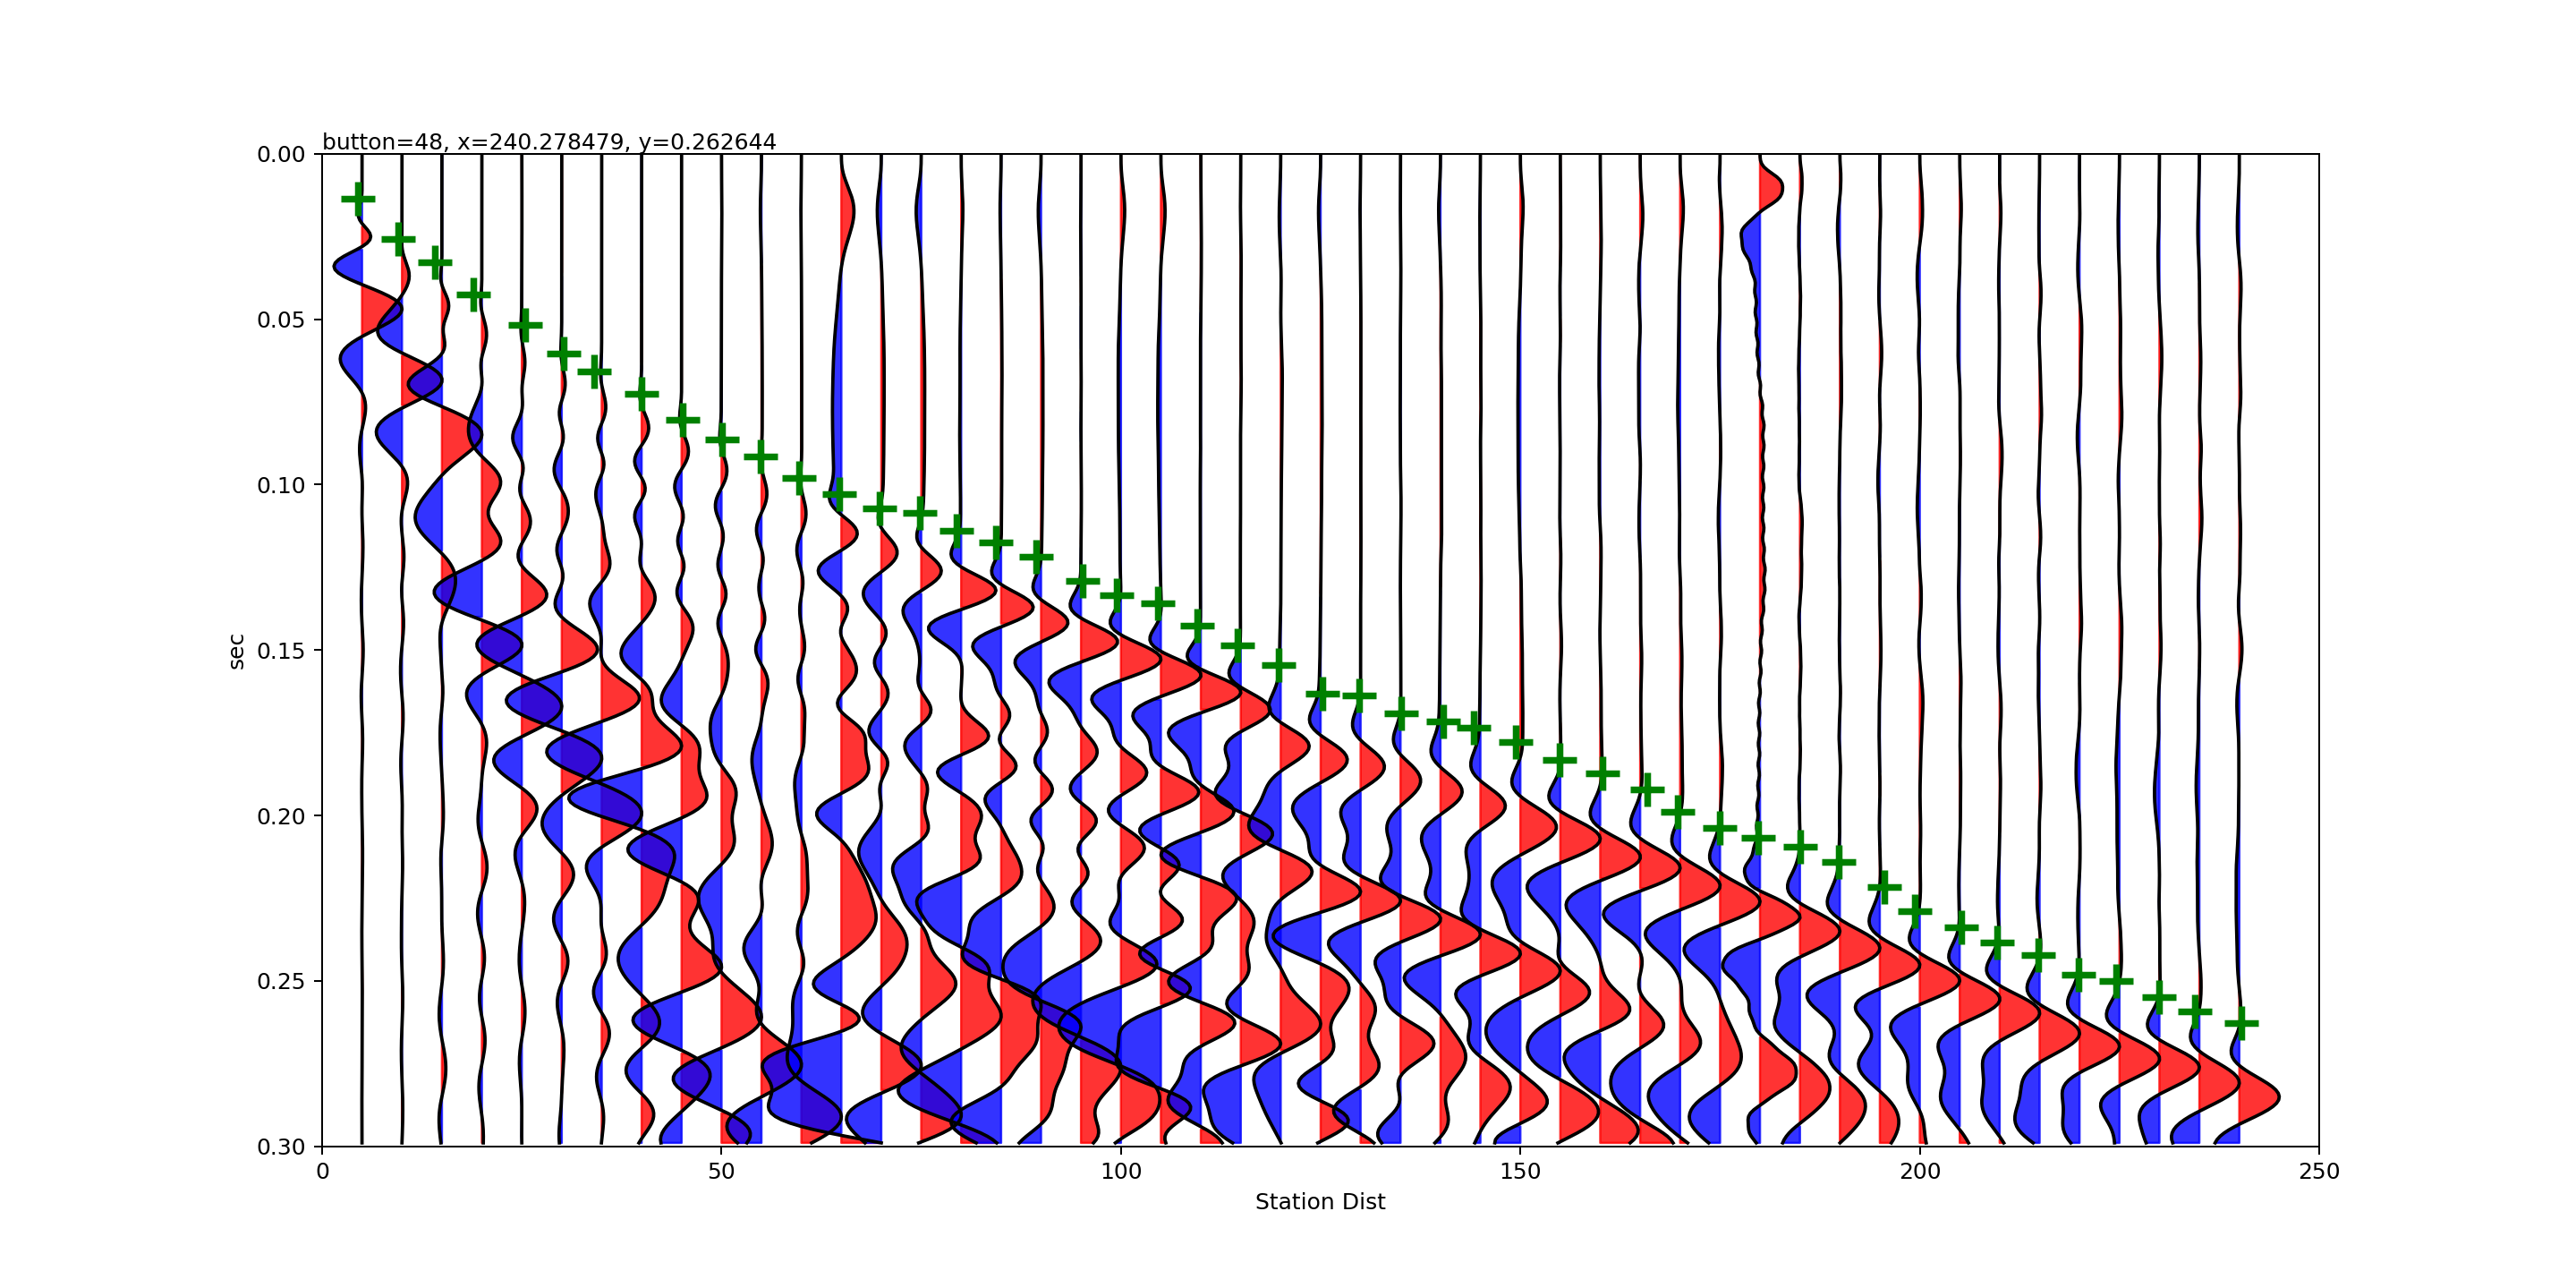

In [159]:
picks=[]
fig, ax =plotseis(seis1,doublecolor=True)
filename='tt1.npy'
text=ax.text(0,0, "", va="bottom", ha="left")
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


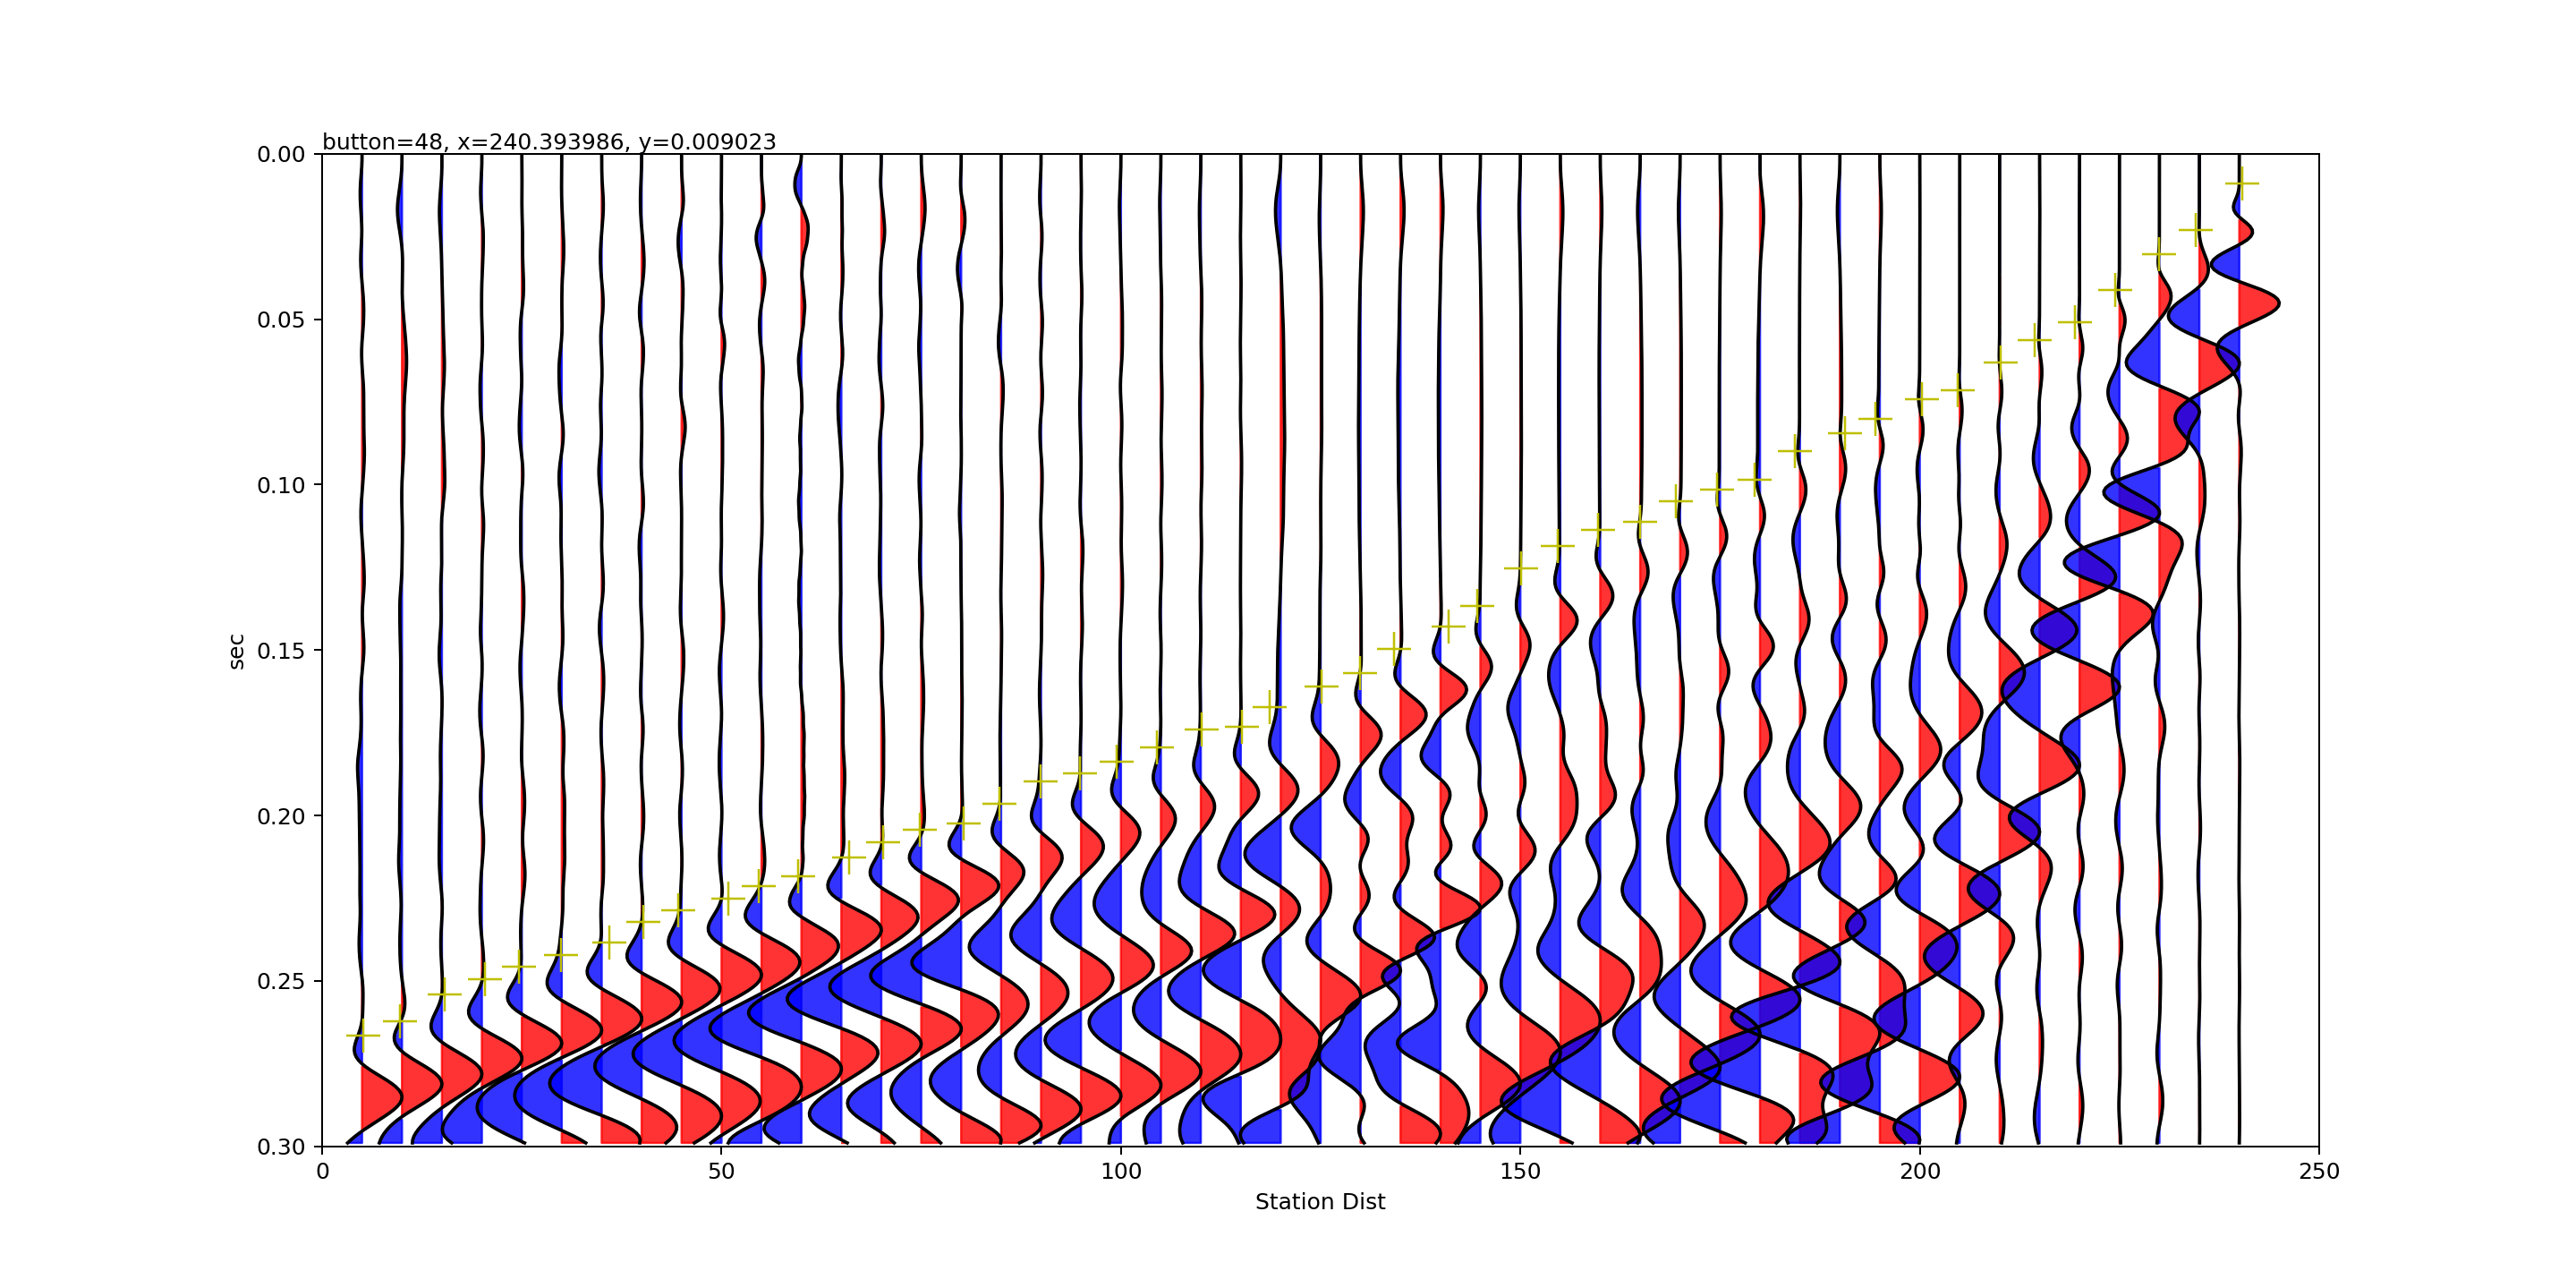

In [146]:
picks=[]
fig, ax =plotseis(seis2,doublecolor=True)
filename='tt2.npy'
text=ax.text(0,0, "", va="bottom", ha="left")
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


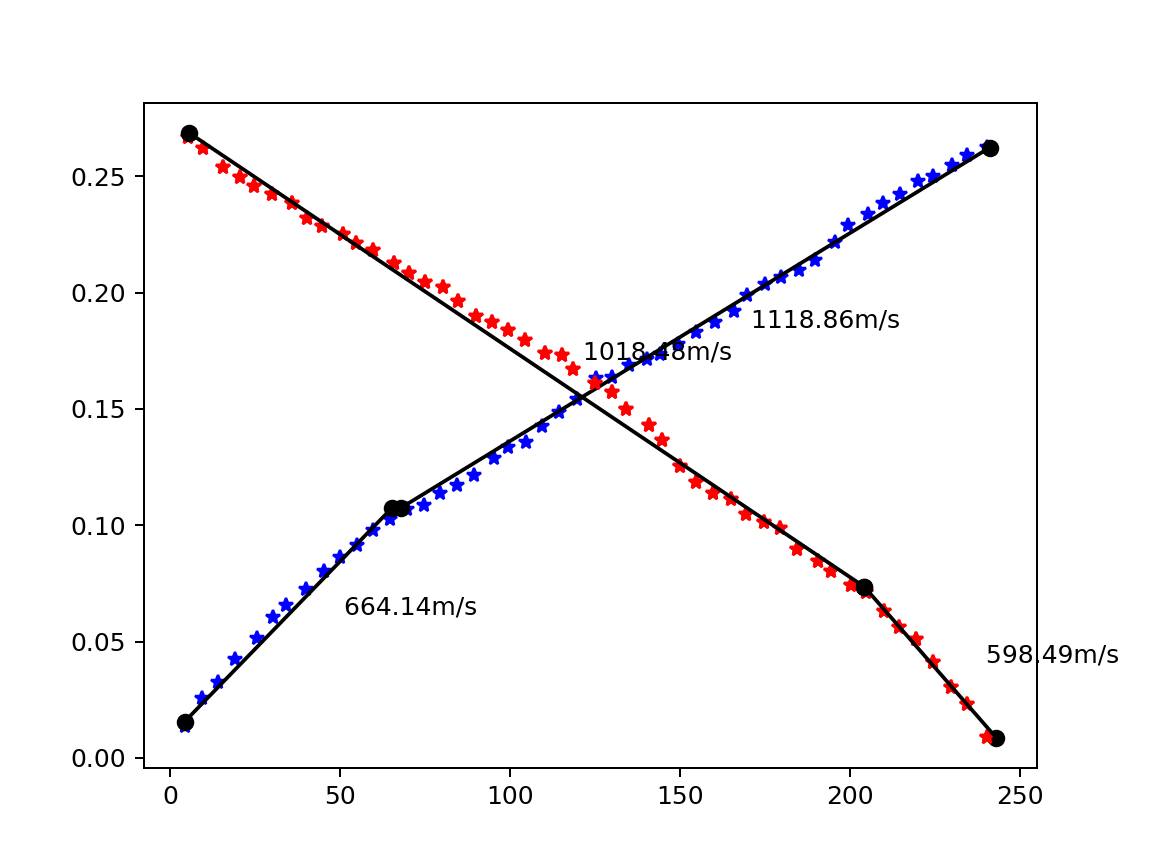

In [164]:
# Keep track of x/y coordinates
lines = []
xcoords = []
ycoords = []
tint=[]
vr=[]
def onclick2(event):
    xcoords.append(event.xdata)
    ycoords.append(event.ydata)
    ax.plot(event.xdata,event.ydata,'ko')
    if len(xcoords)==2:
        lines.append(ax.plot(xcoords,ycoords,'k-'))
        x,y=lines[-1][0].get_data()
        p = np.polyfit(x,y, 1)
        tint.append(np.polyval(p,0))
        vr.append(1/p[0])
        ax.text(np.average(xcoords),np.average(ycoords),'       %.2f'%(abs(1/p[0]))+'m/s')
        xcoords[:] = []
        ycoords[:] = []
    if len(lines)==2:
        plt.plot(abs(tt2[:,0]),tt2[:,1],'r*')
    # Refresh the plot
    fig.canvas.draw()


fig, ax = plt.subplots()

tt1=np.load('tt1.npy')
tt2=np.load('tt2.npy')

plt.plot(abs(tt1[:,0]),tt1[:,1],'b*')
# plt.plot(abs(tt2[:,0]),tt2[:,1],'r*')

connection_id = fig.canvas.mpl_connect('button_press_event', onclick2)
# fig.canvas.mpl_connect('pick_event', onpick)
# lines[0][0].get_data()


In [120]:
vr=np.array(vr).reshape((2,-1))
tint=np.array(tint).reshape((2,-1))


In [ ]:
% 
% rlength=235;
% vr =    [0.5297    0.8713    1.1765;
%    -0.5320   -0.9035   -1.4092]*1e3
% 
% 
% tint =  [ -0.0026    0.0284    0.0635;
%     0.0012    0.0412    0.0958]
% 
% check for reciprocity

for i=2:nb
tforward=tint(1,i)+rlength/vr(1,i)
treverse=tint(2,i)-rlength/vr(2,i)
if abs(tforward-treverse)> 0.02, 'Non Reciprocal DO Step 3 again', return
end
end


n=nb;                % layers
x=rlength;              %length
va= vr(1,1:nb);
vb=-vr(2,1:nb);
tai=tint(1,1:nb);
tbi=tint(2,1:nb);
tai(1)=0;tbi(1)=0;
va(1)=(va(1)+vb(1))/2;
vb(1)=va(1);
      v(1) = (va(1) + vb(1))*.5; 
      for m = 2:n 
      k = 1 ;
      alph(1) = asin(v(1)/vb(m)); 
      beta(1) = asin(v(1)/va(m)) ;
        if m==2,     
        a(1) = (alph(1) + beta(1)) * .5 ;
        w(2) = (alph(1) - beta(1)) * .5 ;
        v(2) = v(1)/sin(a(1));
        end; % if m ==2
      
        if m>2,
        for k=1:100 
         a(1) = alph(1) - w(2) ;
             b(1) = beta(1) + w(2) ;
                 k = k+1 ;
                        vv = v(k)/v(k-1) ;
                            p(k) = asin(vv*sin(a(k-1))) ;
                        q(k) = asin(vv*sin(b(k-1))) ;
                    if(k+1-m) >=0, break, end 
                   a(k) = p(k) - w(k+1) + w(k) ;
                b(k) = q(k) + w(k+1) - w(k); 
            alph(k) = a(k) + w(k+1) ;
        beta(k) = b(k) - w(k+1) ;
        end;  % k loop goto 520 
      
      a(k) = (p(k) + q(k)) * .5;
      b(k) = a(k) ;
      w(k+1) = w(k) + (p(k) - q(k)) * .5 ;
      alph(k) = a(k) + w(k+1) ;
      beta(k) = b(k) - w(k+1) ;
      v(k+1) = v(k)/sin(a(k));
  end ;% m =2
      kk = k-1 ;
      hha = 0.0 ;
      hhb = 0.0 ;
      
      
      if (kk)>0  
          
            for i = 1:kk ;
            hh = cos(alph(i)) + cos(beta(i)) ;
            hh = hh/v(i) ;
            hha = hha + hh*ha(i) ;
            hhb = hhb + hh*hb(i) ;
            end; % for k 
            
      end; % if kk<=0;
      r = v(k)/(cos(alph(k)) + cos(beta(k))) ;
      ha(k) = r*(tai(k+1) - hha) ;
      hb(k) = r*(tbi(k+1) - hhb); 
      da(1) = ha(1) ;
      db(1) = hb(1) ;
      
            if(k-1) > 0
            da(k) = da(k-1) + ha(k) ;
            db(k) = db(k-1) + hb(k);
            end;   % if
            
 end;   % m big loop
 
 % convert to radians
      for j = 2:n 
      w(j) = w(j)*57.2958 + 0.001  ;
      end
      
      'depth A', da';
      'depth B', db';
      'dip', w';
      
      x=[0,rlength];
      y1=[0 0];
      yA=[da(1:nb-1)];
      yB=[db(1:nb-1)];
      ym=max(db);
      yedge=[1.2*ym,1.2*ym];
      figure(4)
      clf
      hold
      for i=1:nb-1
      plot(x,0.3*yedge,'.',x,y1,x,-yedge,'.',x,-[da(i),db(i)],'*-')
  end
  text(x(1)+10,5,['Velocities ',num2str(v(1:3))])
  text(x(1)+10,10,['Depths A  ',num2str(da(1:1))])
  text(x(1)+10,15,['Depths B   ',num2str(db(1:1))])
  text(x(1)+10,20,['Dips    ',num2str(w(2:3))])



  
  fill([0 rlength rlength 0],[0 0 -db(1) -da(1)],1)
%   fill([0 rlength rlength 0],[-da(1) -db(1) -db(2) -da(2)],2)
%   fill([0 rlength rlength 0],[-da(2) -db(2) -100 -100],3)

axis([0,rlength,-100,40])
  title ('Refraction Interpretation')
      figure(4)
      hold
      
      
      
